<a href="https://colab.research.google.com/github/gdomnijl/Neologisms/blob/master/attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
import numpy as np
from sklearn import preprocessing
from keras.layers import Dense, Input, Embedding, Lambda, Layer, Multiply, Dropout, Dot, Bidirectional, LSTM
from keras.models import Model
from keras import backend as K
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import pandas as pd
from scipy.stats import norm
from math import sqrt 


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import matplotlib.pyplot as plt

In [0]:
import re
import os
from os import listdir
from os.path import isfile, join
dir_prefix = '/content/gdrive/My Drive/INFO256/data/'
onlyfiles = [f for f in listdir(dir_prefix) if isfile(join(dir_prefix, f))]

In [0]:
# import codecs, json
# import pandas as pd

# with codecs.open('./data/pwned.json', 'r', 'utf-8') as f:
#     tweets = json.load(f, encoding='utf-8')

# list_tweets = [list(elem.values()) for elem in tweets]
# list_columns = list(tweets[0].keys())
# df = pd.DataFrame(list_tweets, columns=list_columns)

 ## 0.  Reading data

In [0]:
## Compile a list of vocabs available so far
neo_scraped = {}
for f in onlyfiles:
  neo = re.sub(r'_\d{4}', '',f)
  neo = neo.replace('.json', '')
  if neo == 'affluenza (1)':
    print(f)
  if neo not in neo_scraped:
    neo_scraped[neo] = os.stat(join(dir_prefix, f)).st_size
  else:
    neo_scraped[neo] += os.stat(join(dir_prefix, f)).st_size
neo_scraped = sorted(neo_scraped.items(), key=lambda kv: kv[1])
neo_scraped

[('train_x_index', 0),
 ('one-upper', 4036),
 ('elderburb', 5489),
 ('manspread', 25886),
 ('phub', 34255),
 ('one-up', 96673),
 ('earjacking', 123444),
 ('mansplain', 395244),
 ('Rendezbooze', 528803),
 ('hundo', 625630),
 ('ethnoburb', 627113),
 ('Y_test.csv', 801324),
 ('Y_train.csv', 951704),
 ('Copenhagenization', 1189769),
 ('egocasting', 1206219),
 ('pwned', 1350910),
 ('knosh', 1763720),
 ('skrill', 1976074),
 ('grasstops', 2056159),
 ('feardom', 2658872),
 ('hipsterification', 2713610),
 ('hasbian', 2829317),
 ('unicorpse', 3949361),
 ('fauxpology', 4257827),
 ('meep', 4310460),
 ('micropolitan', 4843275),
 ('spime', 7030250),
 ('procrastibaking', 12590892),
 ('lifestreaming', 14325199),
 ('nom', 17815207),
 ('woonerf', 26889813),
 ('walkscore', 32618062),
 ('youthquake', 40565211),
 ('ninja_sex', 81236344),
 ('tweet_df.csv', 139083081),
 ('test_x_index.csv', 168448063),
 ('Grexit', 168604054),
 ('train_x_index.csv', 199939405),
 ('Rickroll', 220321421),
 ('party_foul', 224477

In [0]:
YEAR_START = 2007
YEAR_END = 2019
tweet = {}
def read_yearly_tweets(word_list, dataset_read):
  trouble_shoot_empty = []

  for word in word_list:
    print("reading %s ..." % word)
    if word not in dataset_read:
      df = []
      
      ## if file is named with word + year
      for year in range(YEAR_START, YEAR_END+1):
        data_file_name = "/content/gdrive/My Drive/INFO256/data/" + word + "_" + str(year) + ".json"
        if os.path.isfile(data_file_name):
          if os.stat(data_file_name).st_size == 0:
            trouble_shoot_empty.append(word + "_" + str(year))
          else:
            with open(data_file_name, 'r') as f: 
              js = pd.read_json(f)
              js['neo_word'] = word ## MADE CHANGE
              df.append(js)
            del js
      if len(df) >0:
        whole_df = pd.concat(df,axis = 0)                  
        dataset_read[word] = whole_df
        del whole_df
        continue
      
      ## if file is named with just the word 
      data_file_name = "/content/gdrive/My Drive/INFO256/data/" + word+ ".json"
      
      if os.path.isfile(data_file_name):
        if os.stat(data_file_name).st_size == 0:
            trouble_shoot_empty.append(word + "_" + str(year))
        else:
            #js = pd.read_json(data_file_name)
            whole_df = pd.read_json(data_file_name)
            whole_df['neo_word'] = word
            dataset_read[word] = whole_df
            del whole_df
          
    
  print("These files are for some reason empty:")
  print(trouble_shoot_empty)
  return dataset_read

In [0]:
#smallest_k = 5
word_ls = [x[0] for x in neo_scraped[:-10]] ## read the k files with the smallest memory
word_ls.remove('Grexit')
word_ls.remove('Y_test.csv')
word_ls.remove('Y_train.csv')
word_ls.remove('test_x_index.csv')
word_ls.remove('train_x_index.csv')
word_ls.remove('train_x_index')
word_ls.remove('tweet_df.csv')
#word_ls.remove('Grexit')

remove_ls = ['one-upper', 'one-up', 'elderburb', 'phub', 'manspread', 'earjacking', 'hundo', 'pwned', 'skrill', 'meep', 'nom'] #hundo pwned skrill meep nom
#word_ls += ['party_foul', 'affluenza', 'man_boobs', 'jailbait', 'genopolitics']# 'photobomb']
tweet = read_yearly_tweets(word_ls, tweet)

reading one-upper ...
reading elderburb ...
reading manspread ...
reading phub ...
reading one-up ...
reading earjacking ...
reading mansplain ...
reading Rendezbooze ...
reading hundo ...
reading ethnoburb ...
reading Copenhagenization ...
reading egocasting ...
reading pwned ...
reading knosh ...
reading skrill ...
reading grasstops ...
reading feardom ...
reading hipsterification ...
reading hasbian ...
reading unicorpse ...
reading fauxpology ...
reading meep ...
reading micropolitan ...
reading spime ...
reading procrastibaking ...
reading lifestreaming ...
reading nom ...
reading woonerf ...
reading walkscore ...
reading youthquake ...
reading ninja_sex ...
reading Rickroll ...
reading party_foul ...
reading affluenza ...
reading humblebrag ...
These files are for some reason empty:
[]


word_doc=', '.join(df.text)

searchfor = ['pwned', 'Pwned', 'PWNED']

In [0]:
# # df['label']=np.where(df['text'].str.contains('pwned|Pwned|PWNED'), '1','0')
# # new_df=df[['label','text']]
# with open("pwned.tsv", "w") as f:
#     f.write(word_doc)
# new_df.to_csv("pwned.tsv", sep='\t',index=False,line_terminator='\n')

In [0]:
def load_embeddings(filename, max_vocab_size):

    vocab={}
    embeddings=[]
    with open(filename) as file:
        
        cols=file.readline().split(" ")
        num_words=int(cols[0])
        size=int(cols[1])
        embeddings.append(np.zeros(size))  # 0 = 0 padding if needed
        embeddings.append(np.zeros(size))  # 1 = UNK
        embeddings.append(np.zeros(size))  # 2 = NEO
        vocab["_0_"]=0
        vocab["_UNK_"]=1
        vocab['_NEO_'] = 2
        
        for idx,line in enumerate(file):

            if idx+2 >= max_vocab_size:
                break

            cols=line.rstrip().split(" ")
            val=np.array(cols[1:])
            word=cols[0]
            
            embeddings.append(val)
            vocab[word]=idx+2

    return np.array(embeddings), vocab, size

In [0]:
def read_data(filename, vocab):
    X=[]
    Y=[]
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols=line.rstrip().split("\t")
            label=cols[0]
            # assumes text is already tokenized
            text=cols[1].split(" ")
            X.append(text)
            Y.append(label)
    return X, Y

In [0]:
def get_word_ids(docs, vocab, max_length=200):
    
    doc_ids=[]
    for doc in docs:
        wids=[]
        for token in doc[:max_length]:
            #print("###")
            #print(token)
            if token == '_NEO_':
              val = 2    
            else:
              val = vocab[token.lower()] if token.lower() in vocab else 1
            wids.append(val)
        
        # pad each document to constant width
        for i in range(len(wids),max_length):
            wids.append(0)
        #print(wids)
        doc_ids.append(wids)

    return np.array(doc_ids)

In [0]:
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file= dir_prefix + "../glove.42B.300d.50K.txt"
glove_in_w2v_format= dir_prefix + "../glove.42B.300d.50K.w2v.txt"
_ = glove2word2vec(glove_file, glove_in_w2v_format)

In [0]:
embeddings, vocab, embedding_size=load_embeddings(dir_prefix + "../glove.42B.300d.50K.w2v.txt", 50000)

In [0]:
embeddings.shape

(50001, 300)

### Cleaning and masking

In [0]:
def preprocess(whole_tweet_df):

#whole_tweet_df['tokens'] = whole_tweet_df['text'].apply(lambda x: nlp.tokenizer(re.sub('\n', '', x, count = 10)))

#Use regex to tokenize words in masked tweet
#Output: list of tokens without punctuation and whitespace
 # whole_tweet_df[''] = re.sub('\n', ' ', text, count = 20)
  whole_tweet_df['tokens_sans_punct'] = whole_tweet_df['text'].apply(lambda x: re.sub('\n', '', (re.sub(r'[^\w\s]','',x, count = 10)), count = 10).lower().split(" "))
#  Count number of words in each tweet without punctuation and whitespace,  uses regex
  whole_tweet_df['count'] = whole_tweet_df['tokens_sans_punct'].apply(lambda x: len(x))
  return whole_tweet_df

def mask(neo, token_ls):
  masked = False
  neo = re.sub(r'[^\w\s]','',neo).split(" ")[0] ## clean cases like one-upper
  for i, w in enumerate(token_ls):
   
    if w.lower() == neo.lower(): 
      token_ls[i] = '_NEO_'
      masked = True
  if masked:
    return token_ls
  else:
    return None
      
def mask_neo_token(whole_tweet_df):
    whole_tweet_df['masked_text'] = whole_tweet_df.apply(lambda x: mask(x.neo_word, x.tokens_sans_punct), axis = 1)
    return whole_tweet_df

In [0]:
tweet_df = pd.concat(list(tweet.values()), axis = 0, ignore_index= True)

In [0]:
tweet_df.shape

(1521912, 11)

In [0]:
tweet_df.head(5)

,fullname,html,id,likes,replies,retweets,text,timestamp,url,user,neo_word
0,Skot Philly,"<p class=""TweetTextSize js-tweet-text tweet-te...",1112041374658879488,1,0,0,Then that 'one-upper' asshole went and changed...,2019-03-30 17:18:19,/Skot_Philly/status/1112041374658879489,Skot_Philly,one-upper
1,Ben Tipler,"<p class=""TweetTextSize js-tweet-text tweet-te...",1111827441117548544,2,1,0,"Not to be a one-upper, but since you asked, 12...",2019-03-30 03:08:13,/bentipler/status/1111827441117548547,bentipler,one-upper
2,Miss 20 Something,"<p class=""TweetTextSize js-tweet-text tweet-te...",1111788820343721984,1,1,0,"So you are a ""one-upper""",2019-03-30 00:34:45,/ChrystabelMango/status/1111788820343721984,ChrystabelMango,one-upper
3,WFNZ-AM/FM,"<p class=""TweetTextSize js-tweet-text tweet-te...",1111689195561586688,0,2,1,The #DoucheMadness CHAMPIONSHIP is set! \n\nOn...,2019-03-29 17:58:53,/wfnz/status/1111689195561586690,wfnz,one-upper
4,Kathleen Leavenworth,"<p class=""TweetTextSize js-tweet-text tweet-te...",1111637231779885056,4,1,0,Me: “guess I must’ve caught the cold that’s go...,2019-03-29 14:32:23,/LEENwit_it/status/1111637231779885058,LEENwit_it,one-upper


In [0]:
tweet_df = preprocess(tweet_df)

In [0]:
tweet_df=mask_neo_token(tweet_df)

In [0]:
tweet_df.head()

,fullname,html,id,likes,replies,retweets,text,timestamp,url,user,neo_word,tokens_sans_punct,count,masked_text
0,Skot Philly,"<p class=""TweetTextSize js-tweet-text tweet-te...",1112041374658879488,1,0,0,Then that 'one-upper' asshole went and changed...,2019-03-30 17:18:19,/Skot_Philly/status/1112041374658879489,Skot_Philly,one-upper,"[then, that, _NEO_, asshole, went, and, change...",15,"[then, that, _NEO_, asshole, went, and, change..."
1,Ben Tipler,"<p class=""TweetTextSize js-tweet-text tweet-te...",1111827441117548544,2,1,0,"Not to be a one-upper, but since you asked, 12...",2019-03-30 03:08:13,/bentipler/status/1111827441117548547,bentipler,one-upper,"[not, to, be, a, _NEO_, but, since, you, asked...",13,"[not, to, be, a, _NEO_, but, since, you, asked..."
2,Miss 20 Something,"<p class=""TweetTextSize js-tweet-text tweet-te...",1111788820343721984,1,1,0,"So you are a ""one-upper""",2019-03-30 00:34:45,/ChrystabelMango/status/1111788820343721984,ChrystabelMango,one-upper,"[so, you, are, a, _NEO_]",5,"[so, you, are, a, _NEO_]"
3,WFNZ-AM/FM,"<p class=""TweetTextSize js-tweet-text tweet-te...",1111689195561586688,0,2,1,The #DoucheMadness CHAMPIONSHIP is set! \n\nOn...,2019-03-29 17:58:53,/wfnz/status/1111689195561586690,wfnz,one-upper,"[the, douchemadness, championship, is, set, _N...",16,"[the, douchemadness, championship, is, set, _N..."
4,Kathleen Leavenworth,"<p class=""TweetTextSize js-tweet-text tweet-te...",1111637231779885056,4,1,0,Me: “guess I must’ve caught the cold that’s go...,2019-03-29 14:32:23,/LEENwit_it/status/1111637231779885058,LEENwit_it,one-upper,"[me, guess, i, mustve, caught, the, cold, that...",12,"[me, guess, i, mustve, caught, the, cold, that..."


In [0]:
from itertools import chain
neo_level_df=tweet_df.groupby(['neo_word'])['tokens_sans_punct'].apply(lambda x: list(chain(*x))).reset_index()

In [0]:
neo_level_df

,neo_word,tokens_sans_punct
0,Copenhagenization,"[nora3000, who, wouldnt, like, copenhagenizati..."
1,Rendezbooze,"[lightbulb, cerealrendezvous, point, , inuman,..."
2,Rickroll,"[getting, rickrolld, hopefuly, going, to, see,..."
3,affluenza,"[reading, about, _NEO_, and, getting, lost, in..."
4,earjacking,"[catwomanizer, monster891, jeanotisme, _NEO_, ..."
5,egocasting,"[ah, ik, twitter, weer, eens, tegen, mezelf, l..."
6,elderburb,"[wod, elderburbia, n, suburbs, that, have, a, ..."
7,ethnoburb,"[fremont, in, ny, times, , apparently, were, a..."
8,fauxpology,"[re, hishammudins, apology, where, i, come, fr..."
9,feardom,"[have, we, replaced, freedom, for, _NEO_, the,..."


In [0]:
# word_ls2 = ['Rendezbooze', 'hundo']
# tweet_df = pd.concat([tweet[x] for x in word_ls2], axis = 0, ignore_index = True)

In [0]:
# def mask_neo_token(whole_tweet_df):
#   whole_tweet_df['masked_text'] = whole_tweet_df.apply(lambda x: x.text.lower().replace(x.neo.lower(), '_NEOLOGISM_').split(" "), axis = 1)
#   return whole_tweet_df


In [0]:
remove = tweet_df.masked_text.isnull()
tweet_df_clean = tweet_df[-remove]

In [0]:
tweet_df_clean.head()

,fullname,html,id,likes,replies,retweets,text,timestamp,url,user,neo_word,tokens_sans_punct,count,masked_text
0,Skot Philly,"<p class=""TweetTextSize js-tweet-text tweet-te...",1112041374658879488,1,0,0,Then that 'one-upper' asshole went and changed...,2019-03-30 17:18:19,/Skot_Philly/status/1112041374658879489,Skot_Philly,one-upper,"[then, that, _NEO_, asshole, went, and, change...",15,"[then, that, _NEO_, asshole, went, and, change..."
1,Ben Tipler,"<p class=""TweetTextSize js-tweet-text tweet-te...",1111827441117548544,2,1,0,"Not to be a one-upper, but since you asked, 12...",2019-03-30 03:08:13,/bentipler/status/1111827441117548547,bentipler,one-upper,"[not, to, be, a, _NEO_, but, since, you, asked...",13,"[not, to, be, a, _NEO_, but, since, you, asked..."
2,Miss 20 Something,"<p class=""TweetTextSize js-tweet-text tweet-te...",1111788820343721984,1,1,0,"So you are a ""one-upper""",2019-03-30 00:34:45,/ChrystabelMango/status/1111788820343721984,ChrystabelMango,one-upper,"[so, you, are, a, _NEO_]",5,"[so, you, are, a, _NEO_]"
3,WFNZ-AM/FM,"<p class=""TweetTextSize js-tweet-text tweet-te...",1111689195561586688,0,2,1,The #DoucheMadness CHAMPIONSHIP is set! \n\nOn...,2019-03-29 17:58:53,/wfnz/status/1111689195561586690,wfnz,one-upper,"[the, douchemadness, championship, is, set, _N...",16,"[the, douchemadness, championship, is, set, _N..."
4,Kathleen Leavenworth,"<p class=""TweetTextSize js-tweet-text tweet-te...",1111637231779885056,4,1,0,Me: “guess I must’ve caught the cold that’s go...,2019-03-29 14:32:23,/LEENwit_it/status/1111637231779885058,LEENwit_it,one-upper,"[me, guess, i, mustve, caught, the, cold, that...",12,"[me, guess, i, mustve, caught, the, cold, that..."


### Creating ts Labels

In [0]:
remove_ls = ['one-upper', 'one-up', 'elderburb', 'phub', 'manspread', 'earjacking', 'hundo', 'pwned', 'skrill', 'meep', 'nom'] #hundo pwned skrill meep nom
bursty_ls = ['walkscore','woonerf', 'ethnoburb', 'Rendezbooze', 'Copenhagenization', 'Rendezbooze', 'egocasting', 'feardom', 'hipsterification', 'manspread', 'unicorpse', 'spime', 'youthquake', 'lifestreaming']
sus_ls =  ['mansplain', 'knosh', 'grasstops', 'hasbian', 'fauxpology', 'micropolitan', 'procrastibaking' ,'ninja_sex', 'Rickroll', 'humblebrag', 'affluenza', 'party-foul']

In [0]:
import random
train_ratio = 0.7
def reverse_choice(ls, subls):
  ret = []
  for l in ls:
    if l not in subls:
      ret.append(l)
  return ret
bursty_train = random.sample(bursty_ls, k = int(train_ratio*len(bursty_ls)))
bursty_test = reverse_choice(bursty_ls, bursty_train)
sus_train = random.sample(sus_ls, k = int(train_ratio*len(sus_ls)))
sus_test = reverse_choice(sus_ls, sus_train)

In [0]:
print(bursty_test)
print(sus_test)
print(bursty_train)
print(sus_train)

['woonerf', 'egocasting', 'feardom', 'hipsterification', 'manspread']
['mansplain', 'ninja_sex', 'Rickroll', 'humblebrag']
['spime', 'Rendezbooze', 'unicorpse', 'Rendezbooze', 'Copenhagenization', 'ethnoburb', 'lifestreaming', 'youthquake', 'walkscore']
['procrastibaking', 'party-foul', 'affluenza', 'fauxpology', 'micropolitan', 'knosh', 'grasstops', 'hasbian']


### Manually annotate labels

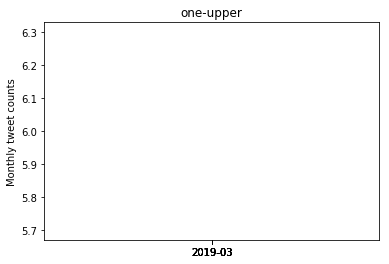

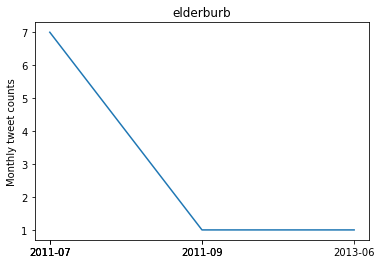

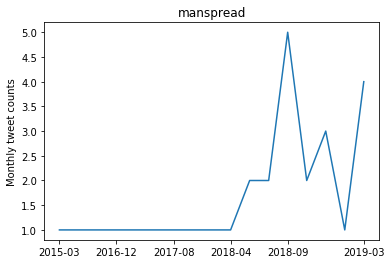

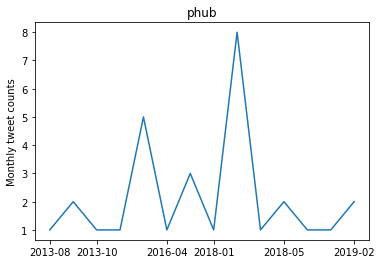

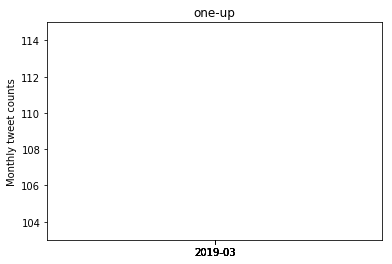

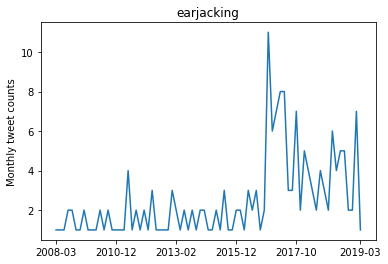

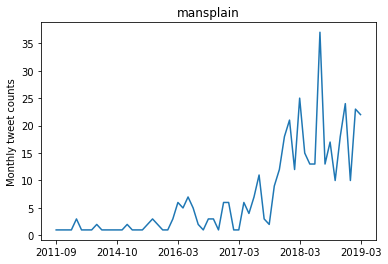

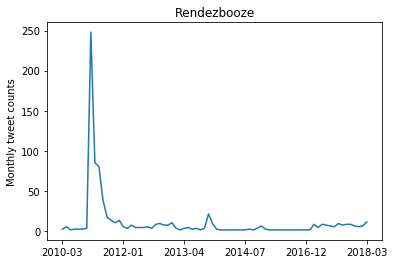

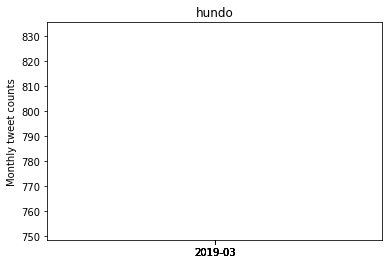

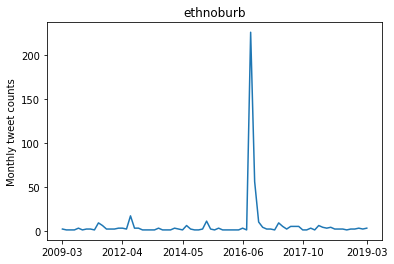

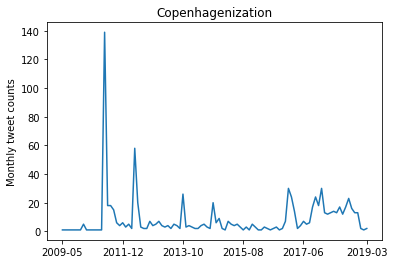

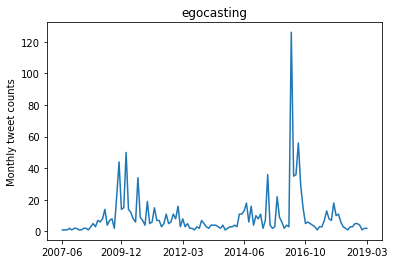

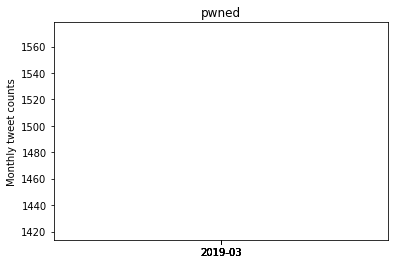

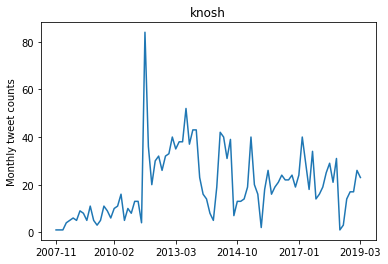

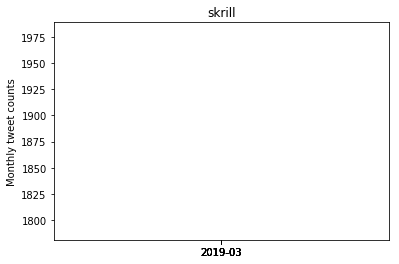

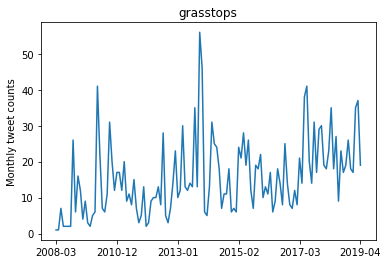

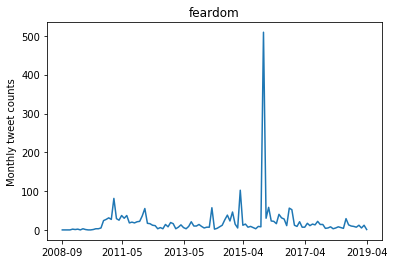

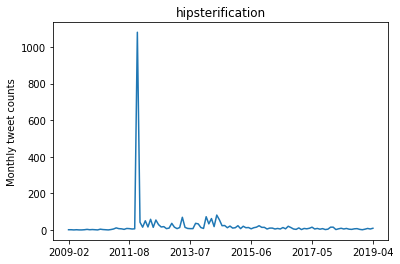

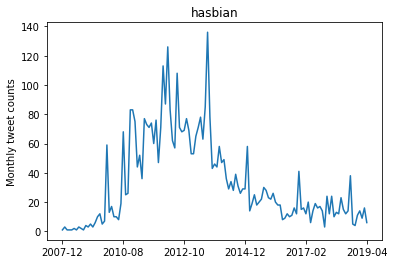

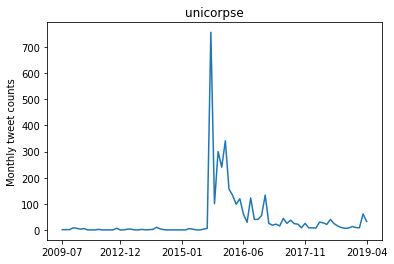

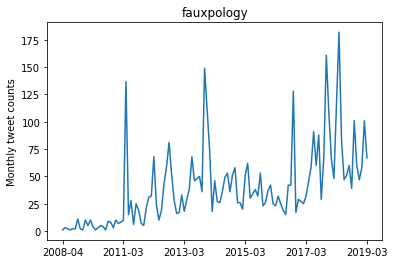

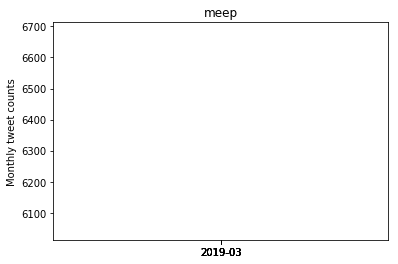

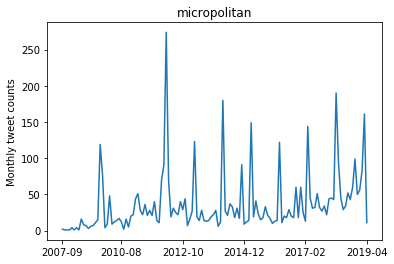

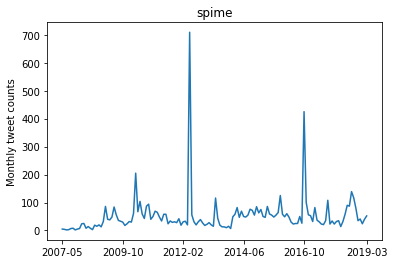

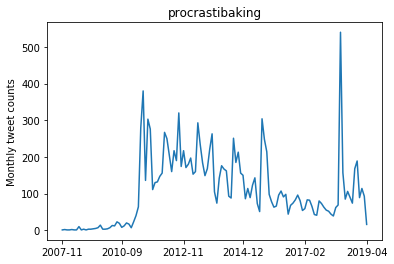

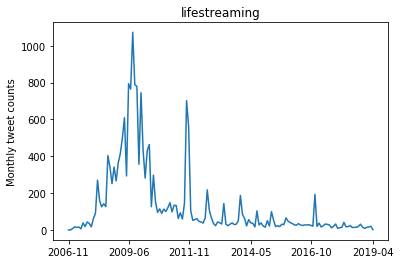

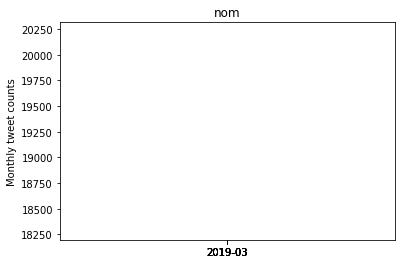

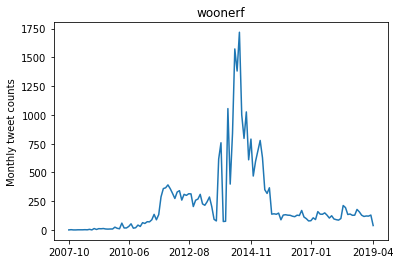

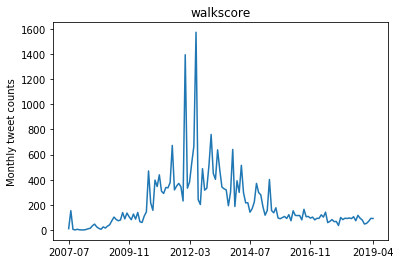

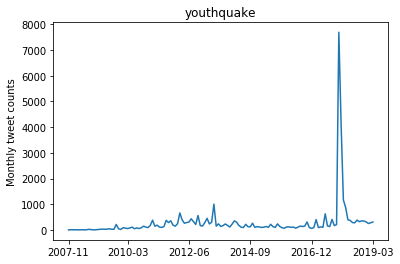

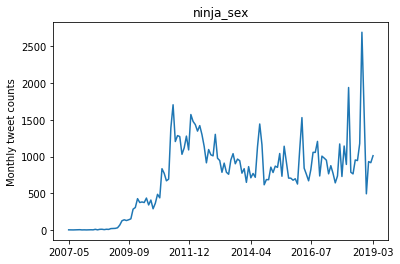

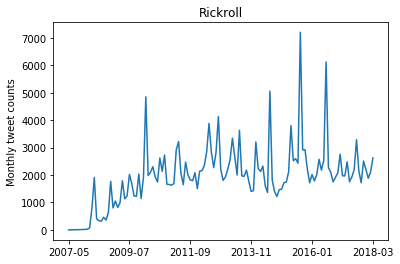

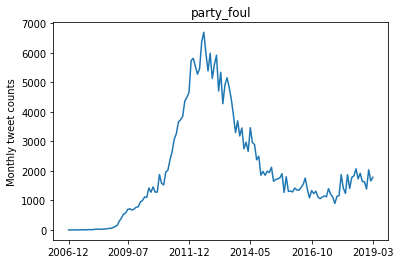

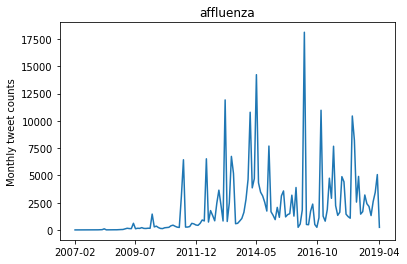

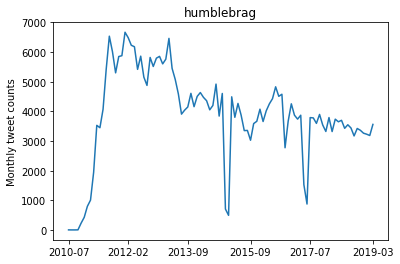

In [0]:
check_ls = word_ls#['Copenhagenization', 'Rendezbooze', 'egocasting', 'elderburb', 'feardom', 'hipsterification', 'manspread', 'phub', 'unicorpse', 'spime', 'youthquake']
for w in check_ls:
  plot_monthly_timeseries(tweet[w], w)

In [0]:
def plot_monthly_timeseries(df, word, return_ts = False):
  df['year_month'] = df.timestamp.apply(lambda x: x.strftime('%Y-%m'))
  ts = df.groupby(['year_month']).text.count()
  if return_ts:
    return ts
  else:
    ts_plot = plt.plot(ts)
    plt.title(word)
    plt.ylabel('Monthly tweet counts')
    seq = np.linspace(0,len(ts.index)-1, num = 6, dtype = np.int32)
    plt.xticks(ts.index[seq])
    plt.show()
    return ts_plot

norm_ts = {}
NUM_DATA_PT = 100
SMOOTH_FACTOR = 0.5
def normalize_timeseries(ts):
  max_val = np.max(ts)
  return ts/max_val

def smooth_ts(ts, param = 0.5):
  ts = plot_monthly_timeseries(tweet[word], word, return_ts = True)
  original_smoo = SimpleExpSmoothing(ts).fit(smoothing_level=param,optimized=False)
  return original_smoo.fittedvalues

def build_normalized_ts(df, word):
  ## use cut to have horizonally normalized entries
  ## expamd to daily first:
  df['time_bin'] = pd.cut(df.timestamp, NUM_DATA_PT)
  ts = df.groupby(['time_bin']).text.count().reset_index().text
  #ts2 = smooth_ts(ts, SMOOTH_FACTOR)
  ts3 = normalize_timeseries(ts)
  norm_ts[word] = ts3
  return

In [0]:
for w in word_ls:
  build_normalized_ts(tweet[w], w)

In [0]:
def build_clustering_df(ts_dict):
  df = pd.concat(ts_dict, axis = 1)
  return df.T


In [0]:
norm_ts_df = build_clustering_df(norm_ts)

In [0]:
def plot_cluster_visual(model, norm_ts_df, k, i):
  #word_cluster = []
  for label, centroid in enumerate(model.cluster_centers_):
    plt.subplot(k, 1, label+1)
    plt.plot(centroid, 'r')
    membership = []
    for ts_id in range(norm_ts_df.shape[0]):
      
      if model.labels_[ts_id] == label:
        membership.append(norm_ts_df.index[ts_id])
        
        #word_cluster.append(membership)
        
        plt.plot(norm_ts_df.iloc[ts_id], alpha = 0.3) #'b', alpha = 0.3)  
        plt.subplots_adjust(top = 3)
    plt.title(membership)
    plt.ylabel("Relative Frequency")
    #plt.margins(y = 10)
    print()
  #print(word_cluster)
  plt.xlabel('Normalized Time Interval')
  plt.show()

######## Given 2 cluster:




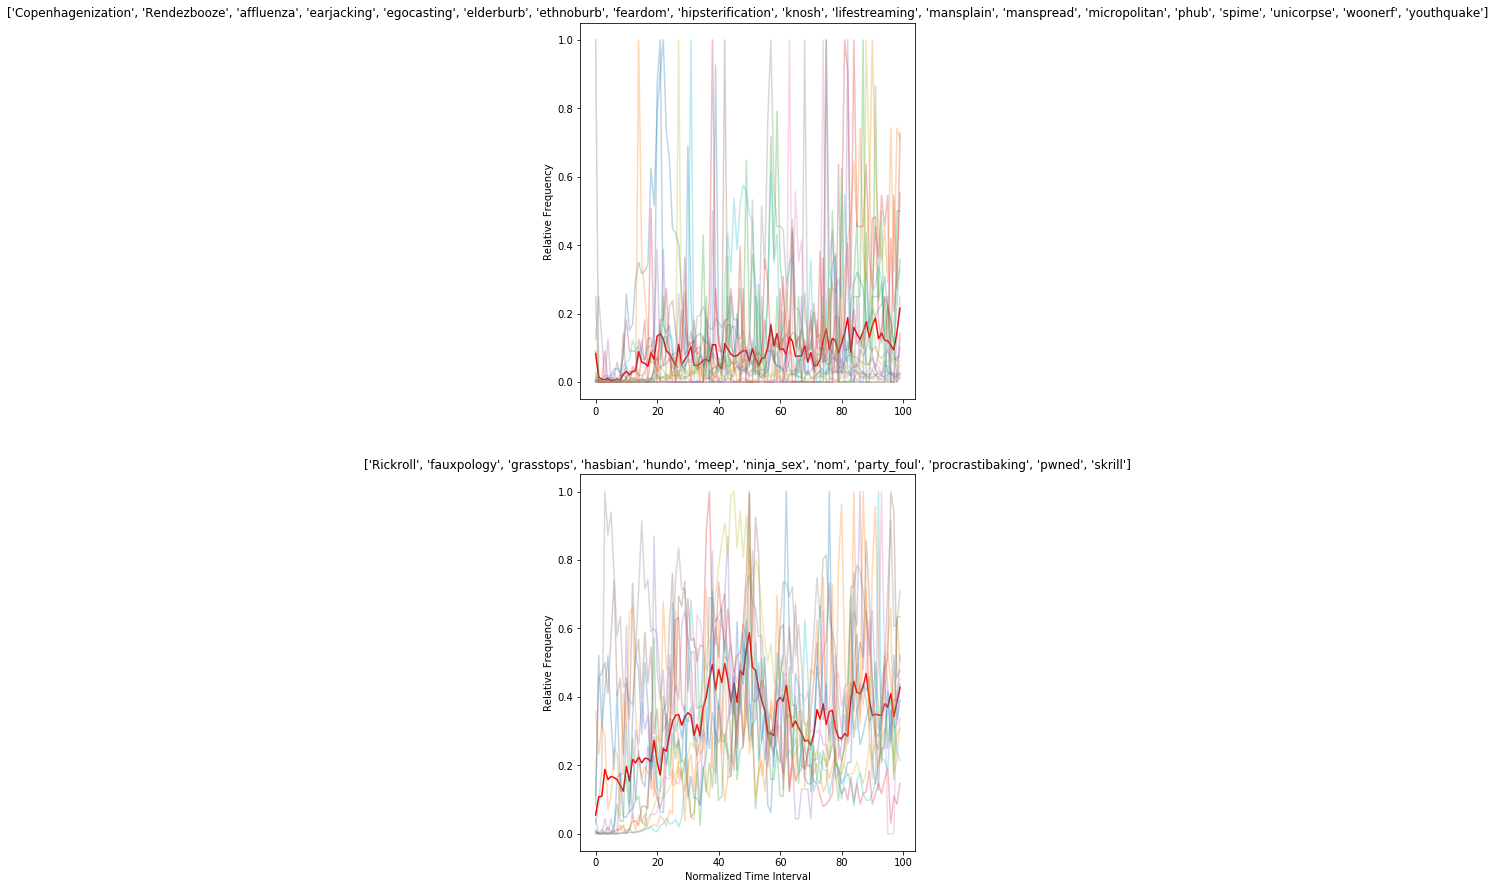

Index(['Copenhagenization', 'Rendezbooze', 'Rickroll', 'affluenza',
       'earjacking', 'egocasting', 'elderburb', 'ethnoburb', 'fauxpology',
       'feardom', 'grasstops', 'hasbian', 'hipsterification', 'hundo', 'knosh',
       'lifestreaming', 'mansplain', 'manspread', 'meep', 'micropolitan',
       'ninja_sex', 'nom', 'party_foul', 'phub', 'procrastibaking', 'pwned',
       'skrill', 'spime', 'unicorpse', 'woonerf', 'youthquake'],
      dtype='object')
######## Given 3 cluster:





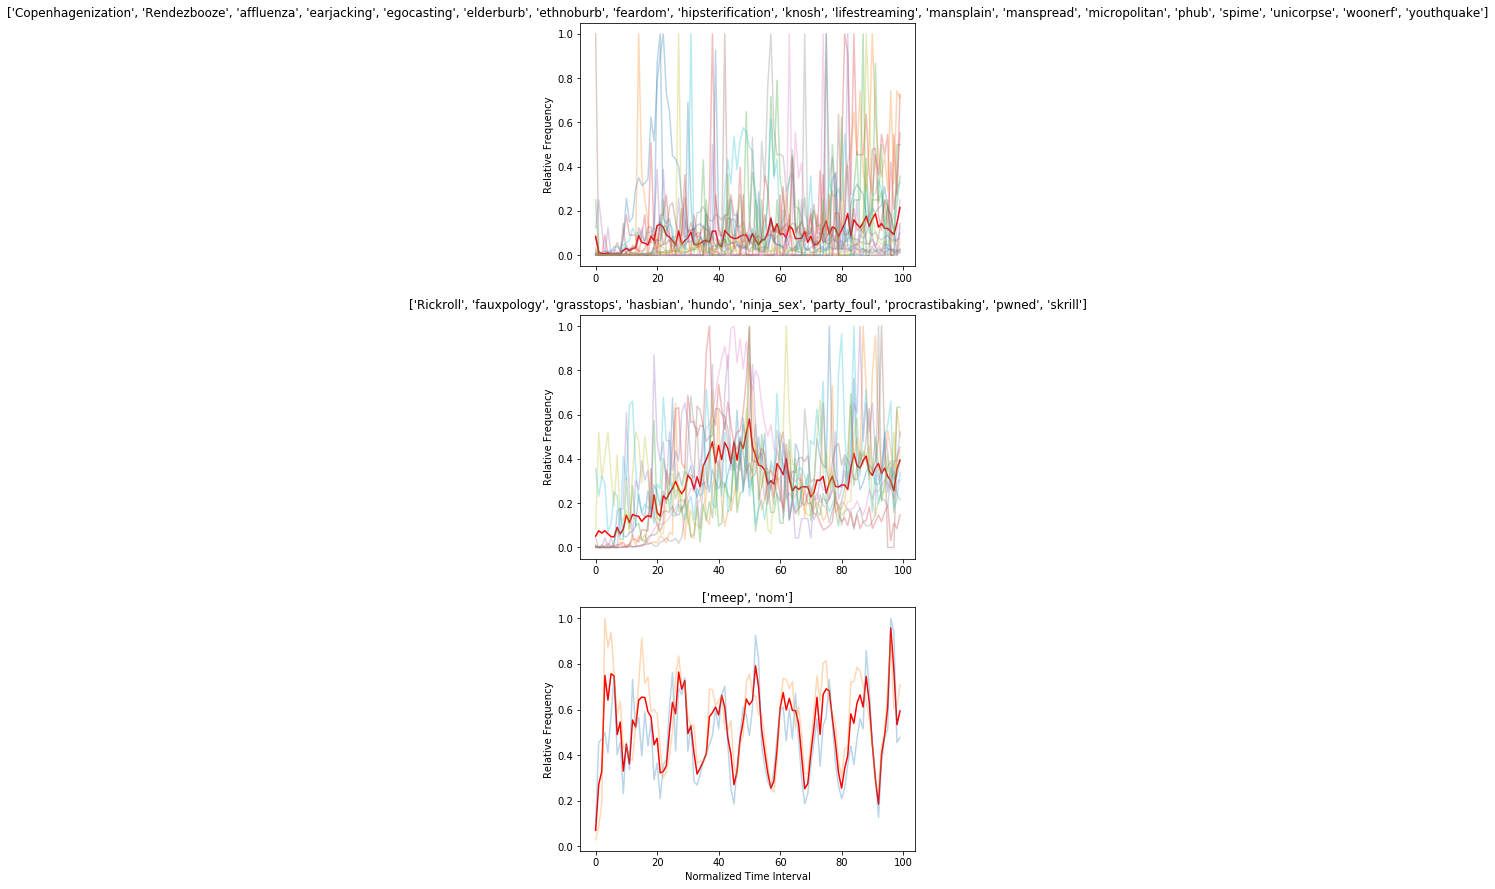

Index(['Copenhagenization', 'Rendezbooze', 'Rickroll', 'affluenza',
       'earjacking', 'egocasting', 'elderburb', 'ethnoburb', 'fauxpology',
       'feardom', 'grasstops', 'hasbian', 'hipsterification', 'hundo', 'knosh',
       'lifestreaming', 'mansplain', 'manspread', 'meep', 'micropolitan',
       'ninja_sex', 'nom', 'party_foul', 'phub', 'procrastibaking', 'pwned',
       'skrill', 'spime', 'unicorpse', 'woonerf', 'youthquake'],
      dtype='object')
######## Given 4 cluster:






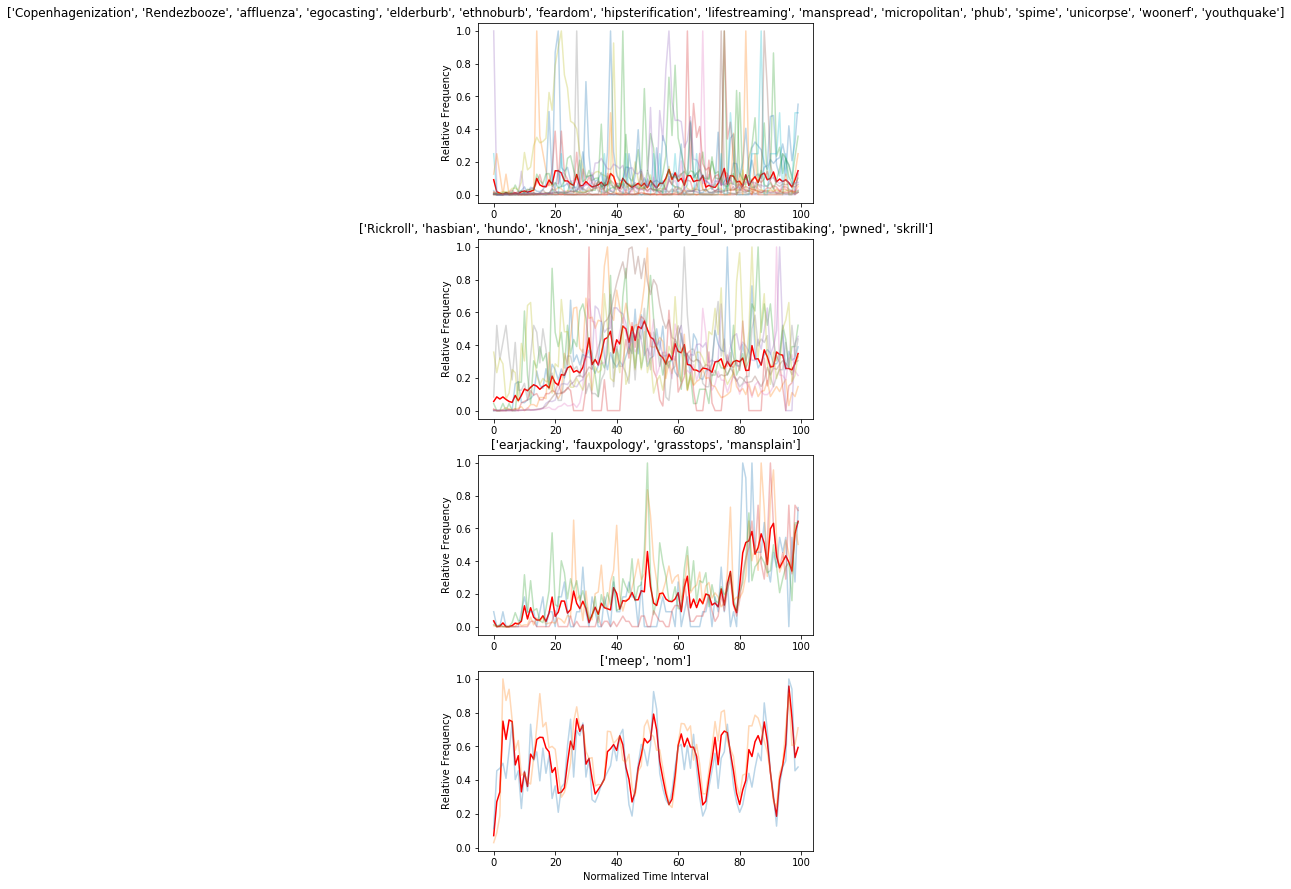

Index(['Copenhagenization', 'Rendezbooze', 'Rickroll', 'affluenza',
       'earjacking', 'egocasting', 'elderburb', 'ethnoburb', 'fauxpology',
       'feardom', 'grasstops', 'hasbian', 'hipsterification', 'hundo', 'knosh',
       'lifestreaming', 'mansplain', 'manspread', 'meep', 'micropolitan',
       'ninja_sex', 'nom', 'party_foul', 'phub', 'procrastibaking', 'pwned',
       'skrill', 'spime', 'unicorpse', 'woonerf', 'youthquake'],
      dtype='object')
######## Given 5 cluster:







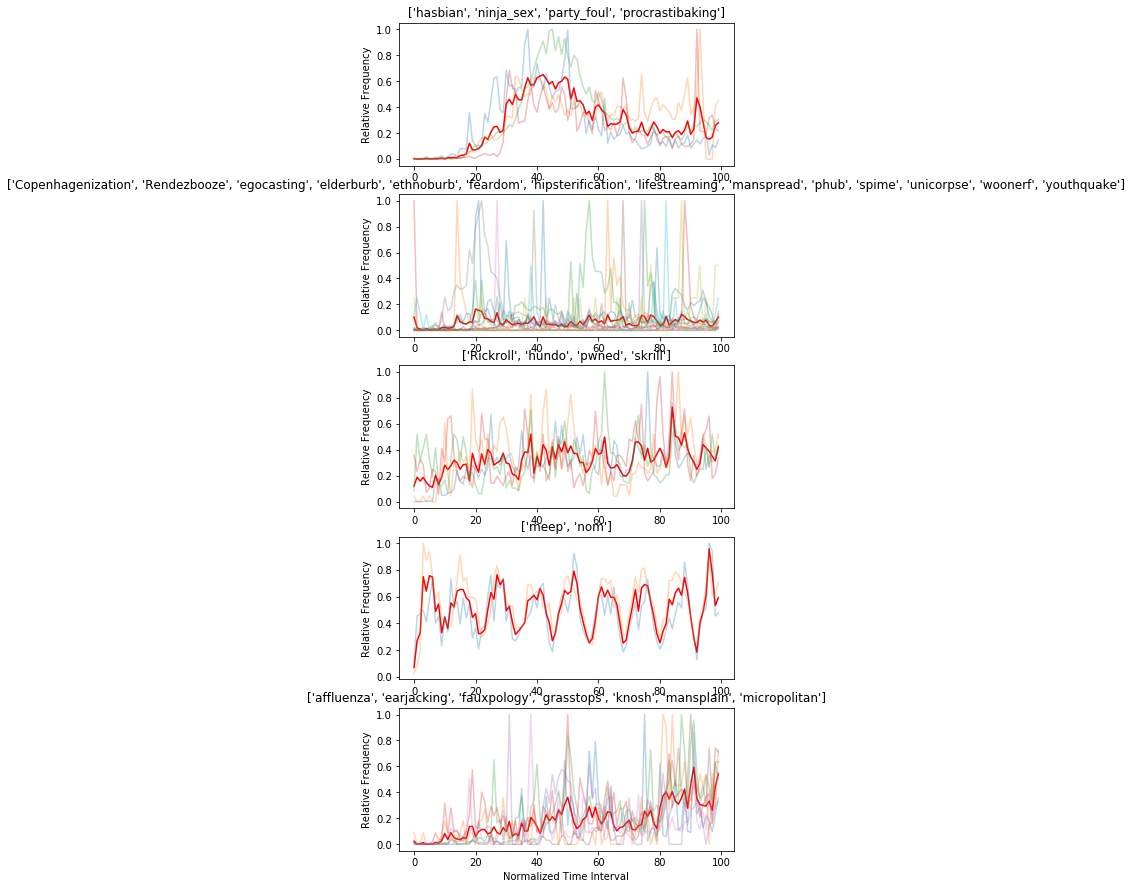

Index(['Copenhagenization', 'Rendezbooze', 'Rickroll', 'affluenza',
       'earjacking', 'egocasting', 'elderburb', 'ethnoburb', 'fauxpology',
       'feardom', 'grasstops', 'hasbian', 'hipsterification', 'hundo', 'knosh',
       'lifestreaming', 'mansplain', 'manspread', 'meep', 'micropolitan',
       'ninja_sex', 'nom', 'party_foul', 'phub', 'procrastibaking', 'pwned',
       'skrill', 'spime', 'unicorpse', 'woonerf', 'youthquake'],
      dtype='object')
######## Given 6 cluster:








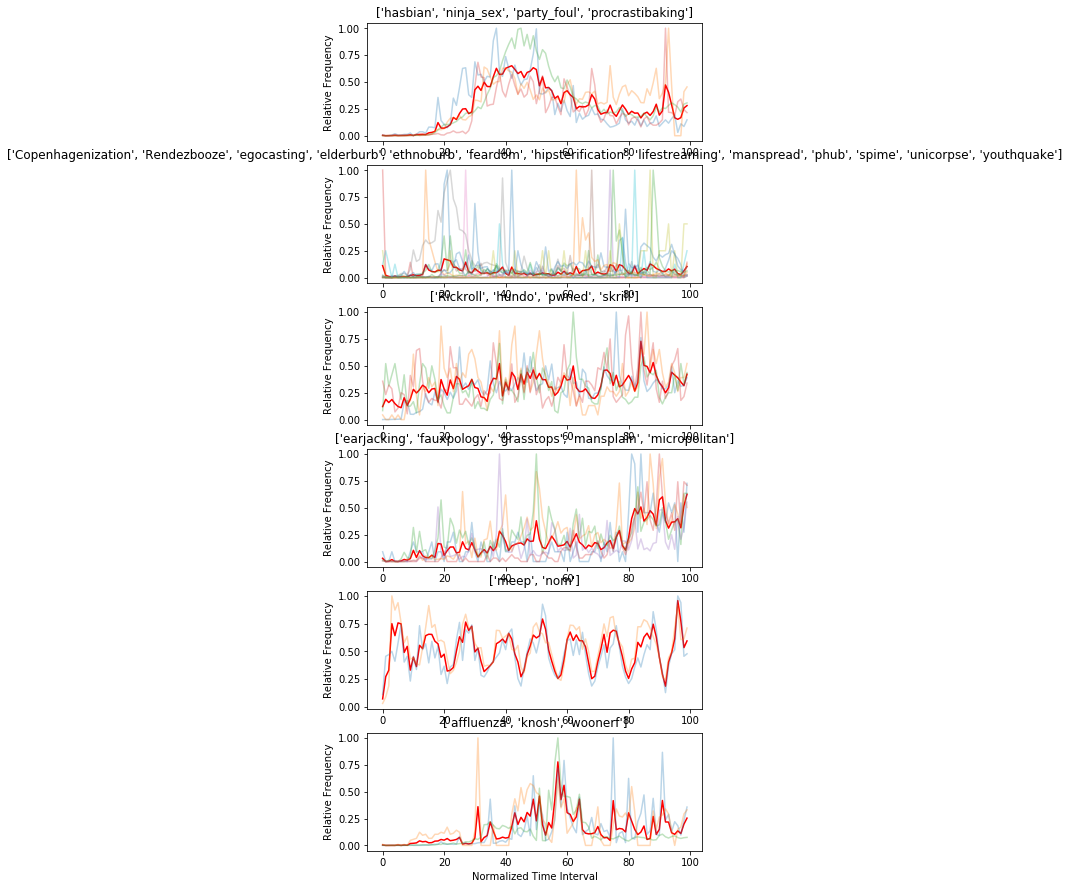

Index(['Copenhagenization', 'Rendezbooze', 'Rickroll', 'affluenza',
       'earjacking', 'egocasting', 'elderburb', 'ethnoburb', 'fauxpology',
       'feardom', 'grasstops', 'hasbian', 'hipsterification', 'hundo', 'knosh',
       'lifestreaming', 'mansplain', 'manspread', 'meep', 'micropolitan',
       'ninja_sex', 'nom', 'party_foul', 'phub', 'procrastibaking', 'pwned',
       'skrill', 'spime', 'unicorpse', 'woonerf', 'youthquake'],
      dtype='object')
######## Given 7 cluster:









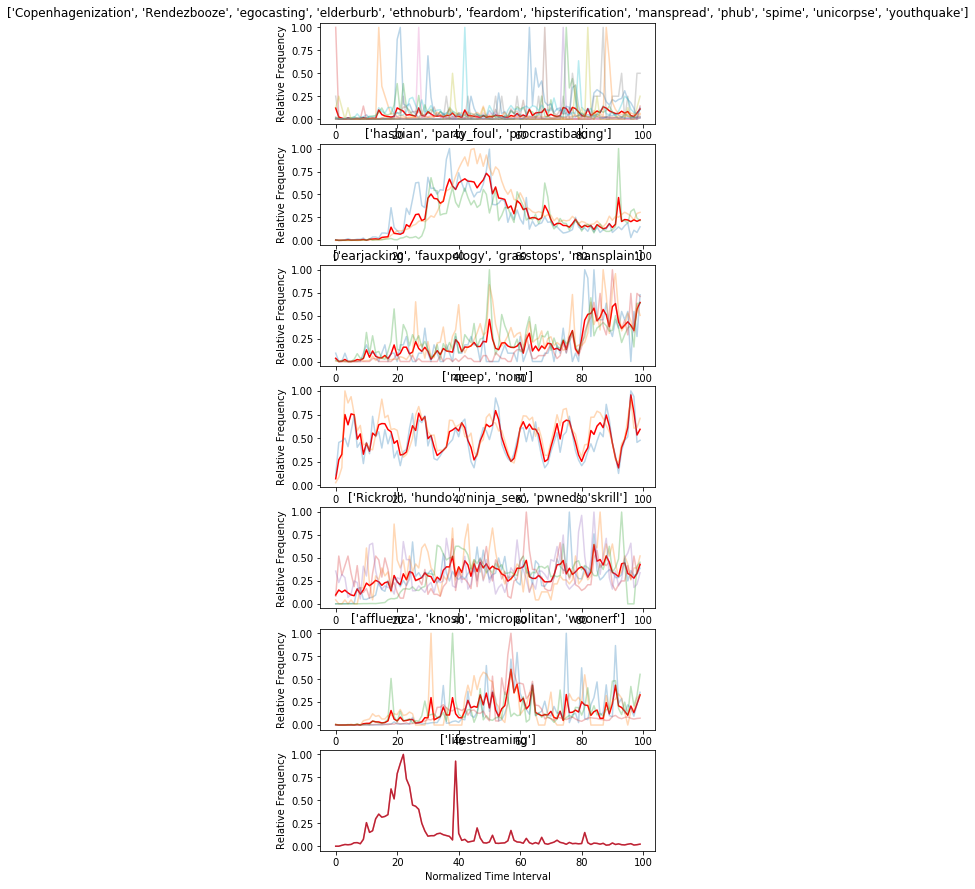

Index(['Copenhagenization', 'Rendezbooze', 'Rickroll', 'affluenza',
       'earjacking', 'egocasting', 'elderburb', 'ethnoburb', 'fauxpology',
       'feardom', 'grasstops', 'hasbian', 'hipsterification', 'hundo', 'knosh',
       'lifestreaming', 'mansplain', 'manspread', 'meep', 'micropolitan',
       'ninja_sex', 'nom', 'party_foul', 'phub', 'procrastibaking', 'pwned',
       'skrill', 'spime', 'unicorpse', 'woonerf', 'youthquake'],
      dtype='object')


In [0]:
from sklearn.cluster import KMeans
models = []
i = 1

remove_word_ts = ['walkscore', 'one-up', 'one-upper', 'humblebrag']
norm_ts_df2 = norm_ts_df
for w in remove_word_ts:
  norm_ts_df2 = norm_ts_df2.drop([w], axis = 0)

for k in [2,3,4,5,6,7]:
  
  model = KMeans(n_clusters=k, random_state=0).fit(norm_ts_df2)
  print("######## Given %d cluster:" % k)
  plot_cluster_visual(model, norm_ts_df2, k, i)
  models.append(model)
  i +=1
  print(norm_ts_df2.index)


### TODO: how to code in tweet neologism identity

In [0]:
remove_neo = tweet_df_clean.neo_word.apply(lambda x: x in remove_ls)

In [0]:
tweet_df_clean2 = tweet_df_clean[-remove_neo]

In [0]:
tweet_df_clean2['bursty'] = tweet_df_clean2.neo_word.apply(lambda x: 1 if x in bursty_ls else 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
neo_level_df['bursty'] = neo_level_df.neo_word.apply(lambda x: 1 if x in bursty_ls else 0)

In [0]:
neo_level_df['train'] = neo_level_df.neo_word.apply(lambda x: 1 if (x in bursty_train) or (x in sus_train) else 0)

In [0]:
neo_level_df.head(20)

,neo_word,tokens_sans_punct,bursty,train
0,Copenhagenization,"[nora3000, who, wouldnt, like, copenhagenizati...",1,1
1,Rendezbooze,"[lightbulb, cerealrendezvous, point, , inuman,...",1,1
2,Rickroll,"[getting, rickrolld, hopefuly, going, to, see,...",0,0
3,affluenza,"[reading, about, _NEO_, and, getting, lost, in...",0,1
4,earjacking,"[catwomanizer, monster891, jeanotisme, _NEO_, ...",0,0
5,egocasting,"[ah, ik, twitter, weer, eens, tegen, mezelf, l...",1,0
6,elderburb,"[wod, elderburbia, n, suburbs, that, have, a, ...",0,0
7,ethnoburb,"[fremont, in, ny, times, , apparently, were, a...",1,1
8,fauxpology,"[re, hishammudins, apology, where, i, come, fr...",0,1
9,feardom,"[have, we, replaced, freedom, for, _NEO_, the,...",1,0


In [0]:
tweet_df_clean2['train'] = tweet_df_clean2.neo_word.apply(lambda x: 1 if (x in bursty_train) or (x in sus_train) else 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
neo_level_df[['neo_word', 'tokens_sans_punct', 'bursty', 'train']].to_csv(dir_prefix+"word_level.csv", index = False)

In [0]:
tweet_df_clean2[['neo_word', 'masked_text', 'bursty', 'train']].to_csv(dir_prefix+"tweet_df.csv", index = False)

In [0]:
train_x_index = get_word_ids(tweet_df_clean2[tweet_df_clean2.train ==1]['masked_text'], vocab, max_length=200)
test_x_index = get_word_ids(tweet_df_clean2[tweet_df_clean2.train ==0]['masked_text'], vocab, max_length=200)

In [0]:
train_x_index = get_word_ids(neo_level_df[neo_level_df.train ==1]['tokens_sans_punct'], vocab, max_length=200)
test_x_index = get_word_ids(neo_level_df[neo_level_df.train ==0]['tokens_sans_punct'], vocab, max_length=200)

In [0]:
y_train = tweet_df_clean2[tweet_df_clean2.train == 1].bursty
y_test = tweet_df_clean2[tweet_df_clean2.train == 0].bursty

In [0]:
y_train = neo_level_df[neo_level_df.train == 1].bursty
y_test = neo_level_df[neo_level_df.train == 0].bursty

In [0]:
print(train_x_index.shape)
print(y_train.shape)

(15, 200)
(15,)


In [0]:
type(Y_train)

numpy.ndarray

In [0]:
# neo_idx = {}
# for i, word in enumerate(word_ls2):
#   neo_idx[word] = i
# label = tweet_df.neo.apply(lambda x: neo_idx[x])

In [0]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(df_index, tweet_df['neo'], test_size=0.2, random_state=42)

In [0]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
Y_train=np.array(le.transform(y_train))
Y_test=np.array(le.transform(y_test))

In [0]:
class AttentionLayerMasking(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(AttentionLayerMasking, self).__init__(**kwargs)


    def build(self, input_shape):
        input_embedding_dim=input_shape[-1]
        
        self.kernel = self.add_weight(name='kernel', 
                            shape=(input_embedding_dim,1),
                            initializer='uniform',
                            trainable=True)
        super(AttentionLayerMasking, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        
        # dot product 
        x=K.dot(x, self.kernel)
        # exponentiate
        x=K.exp(x)
        
        # zero out elements that are masked
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            mask = K.expand_dims(mask, axis=-1)
            x = x * mask
        
        # normalize by sum
        x /= K.sum(x, axis=1, keepdims=True)
        x=K.squeeze(x, axis=2)

        return x

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])

In [0]:
def get_bilstm_with_attention_masking(embeddings, lstm_size=25, dropout_rate=0.25):

    vocab_size, word_embedding_dim=embeddings.shape
    
    word_sequence_input = Input(shape=(None,), dtype='int32')
    
    word_embedding_layer = Embedding(vocab_size,
                                    word_embedding_dim,
                                    weights=[embeddings], 
                                    mask_zero=True,
                                    trainable=False)

    
    embedded_sequences = word_embedding_layer(word_sequence_input)
    bilstm_output = Bidirectional(LSTM(lstm_size, return_sequences=True, activation='tanh', dropout=dropout_rate), merge_mode='concat')(embedded_sequences)

    # first let's transform each word embedding into a new vector to use for measuring its importance
    attention_key_dim=300
    attention_input=Dense(attention_key_dim, activation='tanh')(bilstm_output)

    # next we'll pass those transformed inputs through an attention layer, getting back a normalized
    # attention value a_i for each token i; \forall i, 0 <= a_i <= 1; for a document with N words, 
    # \sum_{i=0}^N a_i = 1
    
    attention_output = AttentionLayerMasking(word_embedding_dim, name="attention")(attention_input)
    
    # now let's multiply those attention weights by original inputs to get a weighted average over them
    document_representation = Lambda(lambda x: K.batch_dot(x[0], x[1], axes=1), name='dot')([attention_output,bilstm_output])

    x=Dense(1, activation="sigmoid")(document_representation)
    
    
    model = Model(inputs=word_sequence_input, outputs=x)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    
    return model

In [0]:
bilstm_attention_model=get_bilstm_with_attention_masking(embeddings, lstm_size=25, dropout_rate=0.25)
print (bilstm_attention_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 300)    15000300    input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, None, 50)     65200       embedding_2[0][0]                
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, None, 300)    15300       bidirectional_2[0][0]            
__________________________________________________________________________________________________
attention 

In [0]:
""
import pandas as pd 
pd.DataFrame(test_x_index).to_csv(dir_prefix + 'test_x_index.csv', index = False)

In [0]:
pd.DataFrame(Y_train).to_csv(dir_prefix + 'Y_train.csv', index = False)
pd.DataFrame(Y_test).to_csv(dir_prefix + 'Y_test.csv', index = False)

In [0]:
model=bilstm_attention_model

modelName="bilstm_attention_model.hdf5"
checkpoint = ModelCheckpoint(modelName, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

model.fit(train_x_index, Y_train, 
            validation_data=(test_x_index, Y_test),
            epochs=30, batch_size=32,
            callbacks=[checkpoint])

Train on 15 samples, validate on 20 samples
Epoch 1/30
15/15 [==============================] - 2s 163ms/step - loss: 0.7179 - acc: 0.3333 - val_loss: 0.7021 - val_acc: 0.3500
Epoch 2/30
15/15 [==============================] - 0s 24ms/step - loss: 0.6835 - acc: 0.5333 - val_loss: 0.7231 - val_acc: 0.3000
Epoch 3/30
15/15 [==============================] - 0s 24ms/step - loss: 0.7087 - acc: 0.3333 - val_loss: 0.7351 - val_acc: 0.2500
Epoch 4/30
15/15 [==============================] - 0s 24ms/step - loss: 0.6758 - acc: 0.5333 - val_loss: 0.7469 - val_acc: 0.2500
Epoch 5/30
15/15 [==============================] - 0s 24ms/step - loss: 0.7104 - acc: 0.5333 - val_loss: 0.7538 - val_acc: 0.2500
Epoch 6/30
15/15 [==============================] - 0s 24ms/step - loss: 0.6729 - acc: 0.6000 - val_loss: 0.7594 - val_acc: 0.2500
Epoch 7/30
15/15 [==============================] - 0s 24ms/step - loss: 0.6757 - acc: 0.6667 - val_loss: 0.7660 - val_acc: 0.2500
Epoch 8/30
15/15 [====================

In [0]:
model.layers

In [0]:
Pen_ultimate_layer=model.layers[3].get_weights()[0]

In [0]:
Pen_ultimate_layer.shape

(50, 300)

In [0]:
pred_unicorpse = model.predict(test_x_index[unicorpse])

In [0]:
np.mean(pred_unicorpse[:100])

0.4201187

In [0]:
unicorpse = test.neo_word == 'feardom' 0.4201187 #'grasstops' 0.486 #'ethnoburb' first 100 0.412 -0.136  # 'lifestreaming' first 100 0.35402793
test[unicorpse].shape

(2317, 16)

In [0]:
test = tweet_df_clean2[tweet_df_clean2.train ==0]
#test['pred'] = pred

In [0]:
test.groupby('neo_word').pred.value_counts()

AttributeError: ignored

In [0]:
print(train_x_index.shape)
print(test_x_index.shape)
print(Y_train.shape)
print(Y_test.shape)

(475851, 200)
(400661, 200)
(626690,)
(249822,)


# New Section

In [0]:
def analyze(model, doc):
    
    words=doc.split(" ")
    text = get_word_ids([words], vocab, max_length=len(words))
   
    inp = model.input                                    
    outputs = [layer.output for layer in model.layers[1:]]       
    functor = K.function([inp, K.learning_phase()], outputs) 

    test = text[0]
    orig=words
    attention_weights=[]
    test=test.reshape((1,len(words)))
    layer_outs = functor([test, 0.])

    # in this model, attention is the third layer
    attention_layer=layer_outs[3]
    
    for i in range(len(words)):
        val=attention_layer[0,i]
        attention_weights.append(val)
        print ("%.3f\t%s" % (val, orig[i]))
        
    df = pd.DataFrame({'words':orig, 'attention':attention_weights})
    print(df)
    ax = df.plot.bar(x='words', y='attention', figsize=(10,4))

In [0]:
model=bilstm_attention_model
model.load_weights("bilstm_attention_model.hdf5")

In [0]:
tweet_df_clean2[tweet_df_clean2.neo_word == 'feardom'].text[12062]

'Have we replaced freedom for feardom?'

0.036	Can't
0.082	get
0.061	enough
0.035	of
0.022	the
0.072	lifestreaming,
0.088	workstreaming,
0.057	whateverstreaming
0.027	concepts.
0.002	So
0.007	many
0.057	new
0.075	apps
0.020	will
0.009	come
0.021	tumbling
0.050	out
0.126	of
0.154	this.
                words  attention
0               Can't   0.036052
1                 get   0.081712
2              enough   0.060614
3                  of   0.035448
4                 the   0.021725
5      lifestreaming,   0.072010
6      workstreaming,   0.087790
7   whateverstreaming   0.056719
8           concepts.   0.026546
9                  So   0.002004
10               many   0.006986
11                new   0.056772
12               apps   0.075029
13               will   0.020106
14               come   0.009049
15           tumbling   0.020948
16                out   0.050194
17                 of   0.126022
18              this.   0.154276


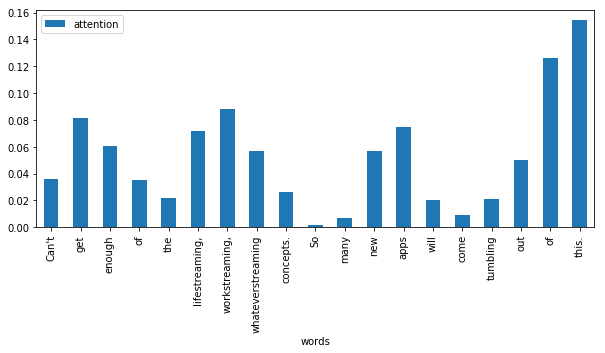

In [0]:
text="Can't get enough of the lifestreaming, workstreaming, whateverstreaming concepts. So many new apps will come tumbling out of this."
analyze(model, text)

0.033	Have
0.016	we
0.163	replaced
0.086	freedom
0.507	for
0.195	feardom
      words  attention
0      Have   0.033452
1        we   0.016120
2  replaced   0.162684
3   freedom   0.086418
4       for   0.506568
5   feardom   0.194757


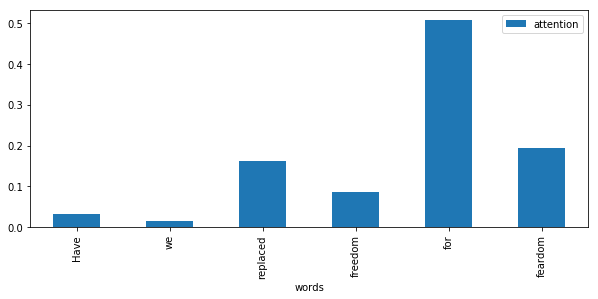

In [0]:
text="Have we replaced freedom for feardom"
analyze(model, text)